<a href="https://colab.research.google.com/github/kuzhuppillil/nU8E2quXIo33gksu/blob/main/Potential_talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.text import sent_tokenize
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re

import gensim
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sentence_transformers import SentenceTransformer

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data = pd.read_csv("/content/drive/Othercomputers/My Laptop/Apziva Projects/Potential Talents/potential-talents - Aspiring human resources - seeking human resources.csv")
data.head(50)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [7]:
len(data) - len(data[["job_title","location","connection"]].drop_duplicates())

51

Observation:



*   'fit' column is the target
*   Columns 'job_title' and 'location' are the main text columns, where NLP techniques need to be applied.
*   'connection' column contains the numerics with exepection of some '+' symbols.
* There are lot of duplicates in the data, these duplicates has the same jobtites, location and connection.
* The locations seem to be in different format and contains some spelling mistakes.





# Text Preprocessing:

In [27]:
#create a copy of data without the duplicates and with orignials indexes
data1 = data.drop_duplicates(subset=["job_title","location","connection"]).copy()
data1.reset_index(drop=True,inplace=True)

In [28]:
#contents in location column
data1.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

In [29]:
#fucntion to clean the location text
def text_cleaning(location):

  #contains unnecessary words like 'Area', 'City' and 'Greater, removing them
  location= re.sub("Area","",location)
  location= re.sub("Greater","",location)
  location= re.sub("City","",location)

  #fixing spelling and language check
  location = re.sub("Kanada","Canada",location)
  location = re.sub("Amerika Birleşik Devletleri","United States of America",location)
  location = re.sub("İzmir, Türkiye","izmir, Turkey",location)

  #fixing format
  location = re.sub("Dallas/Fort Worth","Dallas, Fort Worth",location)
  location = re.sub("New York, New York","New York",location)

  #fixing whitespace at start and end of names
  location = re.sub("^\s+|\s+$","",location)

  location = location.lower()

  return location

data1.location = data1.location.apply(lambda x: text_cleaning(x))
data1.location.unique()

array(['houston, texas', 'canada', 'raleigh-durham, north carolina',
       'denton, texas', 'izmir, turkey', 'new york', 'san francisco bay',
       'philadelphia', 'lake forest, california', 'atlanta, georgia',
       'chicago, illinois', 'austin, texas', 'jackson, mississippi',
       'grand rapids, michigan', 'virginia beach, virginia',
       'monroe, louisiana', 'boston', 'san jose, california',
       'dallas, fort worth', 'united states of america',
       'baton rouge, louisiana', 'myrtle beach, south carolina',
       'chattanooga, tennessee', 'los angeles, california',
       'highland, california', 'gaithersburg, maryland',
       'baltimore, maryland', 'milpitas, california', 'atlanta',
       'chicago', 'torrance, california', 'long beach, california',
       'bridgewater, massachusetts', 'lafayette, indiana',
       'kokomo, indiana', 'las vegas, nevada', 'cape girardeau, missouri',
       'los angeles', 'katy, texas'], dtype=object)

In [30]:
#function to clean the text body, tokenization and lemmatization

lemmatizer = WordNetLemmatizer()

def text_process(text):

  #Filtering out the non-alphabets
  text = re.sub(r"[^a-zA-z\'\s]","",text)

  #converted all text to lowercase for consistency
  text = text.lower()

  #Spell check, form check etc
  text = re.sub("hr","human resources",text)
  text = re.sub("hris","human resource information system",text)


  words = nltk.word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
  cleaned_text = ' '.join(lemmatized_words)

  return cleaned_text


data1["job_title"] = data1.job_title.apply(lambda x: text_process(x))



resource        38
human           37
aspiring        13
professional    10
seeking         10
manager          7
student          6
university       6
management       5
business         5
dtype: int64


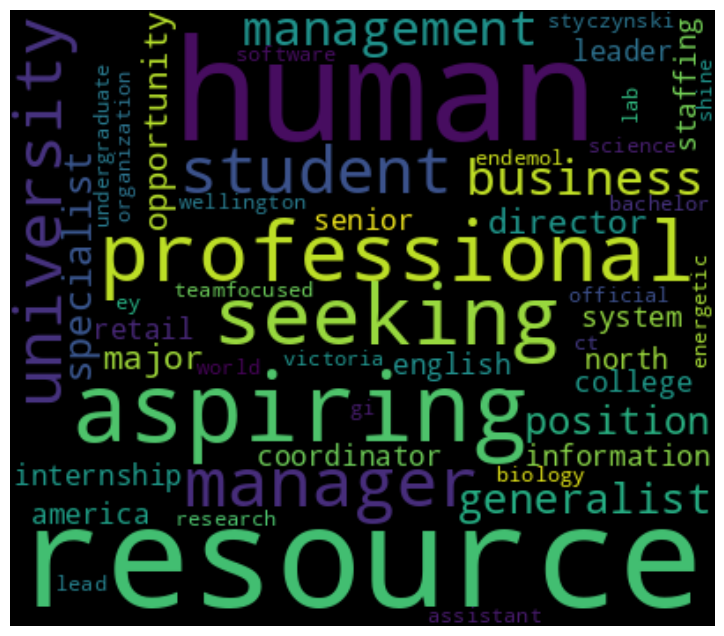

In [31]:
#Frequency count of words

def freq(text):
  word_list = []

  for word in text.str.split():
    word_list.extend(word)
  freq_word = pd.Series(word_list).value_counts()

  return freq_word

word_freq = freq(data1.job_title)


print(word_freq[:10])


wc =  WordCloud(width = 400, height = 350, max_words= 50, background_color= 'black').generate_from_frequencies(word_freq)
plt.figure(figsize =(12,8))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis('off')
plt.show()


Observation:



*   Our dataset altough very small containes relavent keywords that matches our objective.


In [32]:
keywords = "aspiring human resources"

# BOW

In [33]:
#Bag Of Words

cv = CountVectorizer(ngram_range=(1,2),max_features=10)


X=cv.fit_transform(data1.job_title)
keyword_vectors = cv.transform([keywords])

similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_BOW'] = similarity_scores.max(axis=0)


#TF-IDF

In [34]:
#TF-IDF
tiv = TfidfVectorizer(ngram_range=(1,2),max_features = 10)

X = tiv.fit_transform(data1.job_title)
keyword_vectors = tiv.transform([keywords])

similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_TFIDF'] = similarity_scores.max(axis=0)


# Observations:


*   Bag-of-words models matched based on word combinations but could not capture semantic meaning.
*   TF-IDF weighted keywords but still missed identifying some key terms, in our case the search keywords are the most frequent. Since it uses the the concept of rare words, athough it does captures the word importance it's still not effective for our objective.









# Word2Vec

In [35]:

# Tokenizing job titles
vocab = [text.split() for text in data1.job_title]

# Training Word2Vec model using the vocabulary
w2v = Word2Vec(vocab, window=3, min_count=3)

# Getting vectors for keywords
keyword_vectors = [w2v.wv[word] for word in word_tokenize(keywords) if word in w2v.wv.index_to_key]
keyword_vectors = np.mean(keyword_vectors, axis=0).reshape(1, -1)

def avg_word2vec(text):
    words = [word for word in text.split() if word in w2v.wv.index_to_key]
    if not words:
        return np.zeros(w2v.vector_size)
    return np.mean([w2v.wv[word] for word in words], axis=0)

X = [avg_word2vec(text) for text in data1.job_title]


similarity_scores = cosine_similarity(keyword_vectors, X)
data1['fit_Word2Vec'] = similarity_scores[0]



Observation:


*   Word2Vec's word embeddings provided a better fit score by encoding semantic similarity between the keywords and job titles. This addressed the limitations of BOW/TF-IDF models.



# Pretrained Model: BERT (all-MiniLM-L6-v2)

In [36]:
embedder = SentenceTransformer('all-mpnet-base-v2')
bert_embeddings = embedder.encode(data1.job_title)

keyword = embedder.encode(keywords).reshape(1, -1)

bert_similarity= cosine_similarity(keyword,bert_embeddings)
data1['fit_BERT'] = bert_similarity[0]
data1 = data1.sort_values(by='fit_BERT', ascending=False)
data1.head(50)

,id,job_title,location,connection,fit,fit_BOW,fit_TFIDF,fit_Word2Vec,fit_BERT
2,3,aspiring human resource professional,"raleigh-durham, north carolina",44,NaN,0.654654,0.643466,0.729387,0.873929
45,97,aspiring human resource professional,"kokomo, indiana",71,NaN,0.654654,0.643466,0.729387,0.873929
5,6,aspiring human resource specialist,new york,1,NaN,0.774597,0.874475,0.681710,0.863908
22,74,human resource professional,boston,16,NaN,0.258199,0.125136,0.464945,0.733174
30,82,aspiring human resource professional energetic...,"austin, texas",174,NaN,0.654654,0.643466,0.729387,0.717955
20,72,business management major aspiring human resou...,"monroe, louisiana",5,NaN,0.707107,0.715395,0.525177,0.709208
15,67,human resource staffing recruiting professional,"jackson, mississippi",500+,NaN,0.288675,0.158726,0.464945,0.696336
36,88,human resource management major,"milpitas, california",18,NaN,0.333333,0.230189,0.415775,0.694098
21,73,aspiring human resource manager seeking intern...,"houston, texas",7,NaN,0.577350,0.588830,0.645696,0.691771
24,76,aspiring human resource professional passionat...,new york,212,NaN,0.654654,0.643466,0.729387,0.690014


Observation:


1.   The pretrained BERT sentence encoder further improved the fit score by encoding contextual meaning of the entire job title text, for example it captured titles like "people development" and typos like "chuman resourceso" when the other models failed But at the same time we can also observe high fitness scores for non relavant titles.
2.   We can use combine the fit socres for feature engineering the final fitness score.



# Final fit score

In [37]:
scaler = StandardScaler()
#removed the +symbol from the connection and changed the dtype to int
data1["connection"] = data1["connection"].str.replace("+","",regex = True).astype('float')
data1[["connection_scaled"]] = scaler.fit_transform(data1[["connection"]])

In [42]:
#Filtering out non matching candiatates (BONUS requirement)
# data1.reset_index(drop =True, inplace = True)

#Using weighted sum to create a final fit score, taking into accout the connections of each candiatete
#data1['fit'] = 0.7*data1['fit_Word2Vec'] + 0.2*data1['connection_scaled'] + 0.1*data1['fit_BERT']
data1['fit'] = (
    0.8 * data1['fit_Word2Vec'] +
    0.15 * data1[['fit_BERT','connection_scaled']].mean(axis=1) +
    0.05 * data1['fit_TFIDF']
)

data1 = data1.sort_values(by='fit', ascending=False)

#Threshold - Filtering candidates
data1 = data1[data1["fit"] > 0.08]

data1.head(60)


,id,job_title,location,connection,fit,fit_BOW,fit_TFIDF,fit_Word2Vec,fit_BERT,connection_scaled
12,27,aspiring human resource management student see...,"houston, texas",500.0,0.670478,0.707107,0.741207,0.620990,0.621276,1.200398
24,76,aspiring human resource professional passionat...,new york,212.0,0.657002,0.654654,0.643466,0.729387,0.690014,-0.139091
30,82,aspiring human resource professional energetic...,"austin, texas",174.0,0.645842,0.654654,0.643466,0.729387,0.717955,-0.315830
45,97,aspiring human resource professional,"kokomo, indiana",71.0,0.621611,0.654654,0.643466,0.729387,0.873929,-0.794883
2,3,aspiring human resource professional,"raleigh-durham, north carolina",44.0,0.612193,0.654654,0.643466,0.729387,0.873929,-0.920460
5,6,aspiring human resource specialist,new york,1.0,0.569850,0.774597,0.874475,0.681710,0.863908,-1.120454
8,10,seeking human resource human resourcesis gener...,philadelphia,500.0,0.569812,0.436436,0.260792,0.522213,0.652961,1.200398
27,79,liberal art major aspiring human resource analyst,"baton rouge, louisiana",7.0,0.567277,0.774597,0.874475,0.697212,0.636330,-1.092548
0,1,ct bauer college business graduate magna cum l...,"houston, texas",85.0,0.537231,0.654654,0.643466,0.637174,0.667355,-0.729769
48,100,aspiring human resource manager graduating may...,"cape girardeau, missouri",103.0,0.531130,0.577350,0.588830,0.627383,0.643151,-0.646051


Observation:


*   Incorporated a weighted fit score as an additional feature using the scaled connection count in addition to text relevance. Since connections are an important attribute for recruitment roles it plays a vital importance in HR job role. And the weighted averages will balance the influence of connections and title semantics captured using a combination of fitness scores.
*  The cut-off threshold to eliminate non relavent candidates will help the further make the ranking solution effective.





# Reranking

In [43]:
def rerank(data1, starred_id):
  data1.reset_index(drop =True, inplace = True)
  idx = data1.index[data1['id'] == starred_id].tolist()[0]
  data1[['fit']] = data1[['fit']].astype(str)
  starred_text = data1.iloc[idx][['job_title', 'location', 'fit']].str.cat(sep=' ')

  embedder = SentenceTransformer('all-mpnet-base-v2')
  starred_embed = embedder.encode(starred_text).reshape(1, -1)

  texts = data1['job_title'] + ' ' + data1['location'] + ' ' + data1['fit']
  candidate_embeds = embedder.encode(texts)

  rerank_scores = cosine_similarity(starred_embed, candidate_embeds).reshape(-1, 1)

  data1['rerank_fit'] = rerank_scores


  return data1.sort_values(by='rerank_fit', ascending=False)


print("---RERANKING---")

while True:
    try:
        starred_id = int(input("Enter the selected candidate ID: "))
        if starred_id in data1['id'].values:
            data1 = rerank(data1,starred_id)
            print(data1.head(10)[["id","job_title","location","connection","fit","rerank_fit"]])
            break
        else:
            print("INVALID ID! Enter a valid Candidate ID range.")
    except ValueError:
        print("INVALID INPUT! Please enter a valid integer from Candiate ID range.")



---RERANKING---
Enter the selected candidate ID: 12
    id                                          job_title  \
35  12  svp chuman resourceso marketing communication ...   
28  81  senior human resource business partner heil en...   
30  84  human resource professional world leader gi so...   
13  73  aspiring human resource manager seeking intern...   
2   82  aspiring human resource professional energetic...   
8    1  ct bauer college business graduate magna cum l...   
0   27  aspiring human resource management student see...   
11  13  human resource coordinator intercontinental bu...   
34   4                people development coordinator ryan   
25  78                human resource generalist schwan 's   

                    location  connection                  fit  rerank_fit  
35            houston, texas       500.0   0.0812299544800453    1.000000  
28    chattanooga, tennessee       455.0  0.36635208814942033    0.565960  
30      highland, california        50.0   0.347

Observation:


*   Finally reranking by starring ideal candidates helps surface other potentials similar to that profile, this refines the ranking further using the starred candiate attributes as a baseline.
*   Encoded additional attributes like location to better match candidates.




# **BONUS**

# Rank prediction using SVM Ranker:

In [44]:
X = data1.drop(['job_title','location','connection','rerank_fit'],axis =1)
y = data1['rerank_fit']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [45]:
svm_ranker = SVR(kernel='linear')
svm_ranker.fit(X_train, y_train)
pred = svm_ranker.predict(X_test)

ranking = pd.DataFrame({'id': X_test['id'], 'predicted_score': pred})
ranking = ranking.sort_values(by='predicted_score', ascending=False)


mse = mean_squared_error(y_test, pred)
print('Mean Squared Error:',mse)
print("\nRanking prediction:")
ranking

Mean Squared Error: 0.00200803444489352

Ranking prediction:


,id,predicted_score
24,71,0.470538
12,67,0.454827
23,101,0.448230
29,74,0.439191
32,88,0.435398
20,72,0.431162
7,79,0.411162
1,76,0.409427


Observation:

Applied SVM ranker to reranked data to reduce potential human bias in ranking. Model evaluation showed low MSE, indicating good predictive ability considering the limited dataset.




